# 1. Thư viện

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, BatchNormalization,
    Conv1D, MaxPooling1D, Flatten,
    LSTM
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 2. Thu thập và xử lý dữ liệu

Mounted at /content/drive
Danh sách lớp (count = 14):
['BROWSING', 'CHAT', 'FT', 'MAIL', 'P2P', 'STREAMING', 'VOIP', 'VPN-BROWSING', 'VPN-CHAT', 'VPN-FT', 'VPN-MAIL', 'VPN-P2P', 'VPN-STREAMING', 'VPN-VOIP']


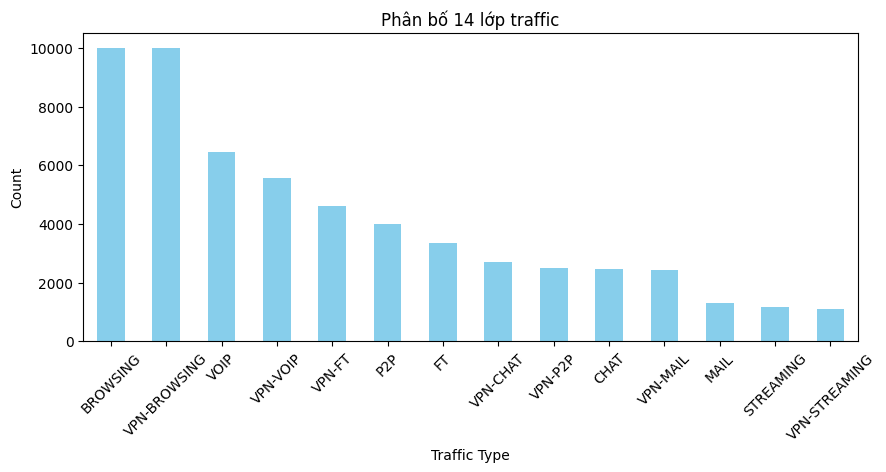

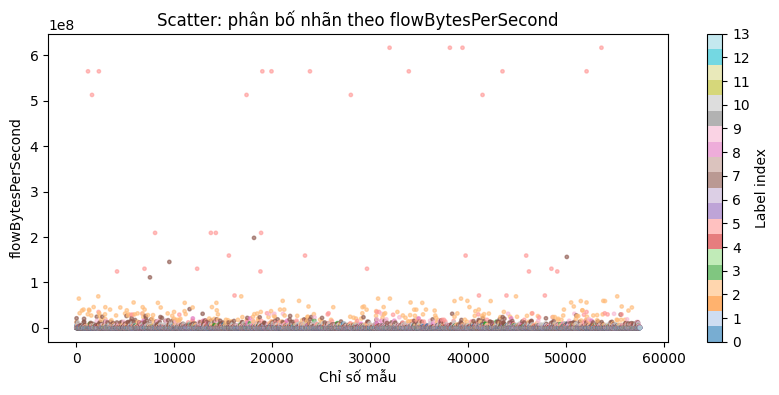

In [2]:
from google.colab import drive
drive.mount('/content/drive')
input_csv = "/content/drive/MyDrive/Goc/consolidated_traffic_data.csv"
df = pd.read_csv(input_csv)
df = df.dropna().reset_index(drop=True)

# Shuffle
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


if "traffic_type" not in df.columns:
    raise ValueError("File CSV phải có cột 'traffic_type' chứa tên lớp (ví dụ 'BROWSING' hoặc 'VPN-BROWSING').")

# Tạo nhãn 14 lớp
# Lấy danh sách lớp
classes = sorted(df["traffic_type"].unique().tolist())
print("Danh sách lớp (count = {}):\n{}".format(len(classes), classes))

# Label encoding
le = LabelEncoder()
df['label_14'] = le.fit_transform(df['traffic_type'])
label_names = le.classes_.tolist()  # index -> tên lớp

# Chọn đặc trưng
feature_cols = [
    'duration','total_fiat','total_biat','min_fiat','min_biat','max_fiat','max_biat',
    'mean_fiat','mean_biat','flowPktsPerSecond','flowBytesPerSecond','min_flowiat',
    'max_flowiat','mean_flowiat','std_flowiat','min_active','mean_active','max_active',
    'std_active','min_idle','mean_idle','max_idle','std_idle'
]

X = df[feature_cols].values
y = df['label_14'].values

# Chuẩn hóa features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#  Trực quan: phân bố nhãn (bar) và scatter theo flowBytesPerSecond
plt.figure(figsize=(10,4))
pd.Series(y).map(lambda v: label_names[v]).value_counts().plot(kind='bar', color='skyblue')
plt.title("Phân bố 14 lớp traffic")
plt.xlabel("Traffic Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,4))
plt.scatter(range(len(df)), df["flowBytesPerSecond"], c=df['label_14'], cmap='tab20', s=6, alpha=0.6)
plt.title("Scatter: phân bố nhãn theo flowBytesPerSecond")
plt.xlabel("Chỉ số mẫu")
plt.ylabel("flowBytesPerSecond")
plt.colorbar(ticks=range(len(label_names)), label='Label index')
plt.show()

# 3. Chia dữ liệu

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

n_features = X_train.shape[1]
X_train_r = X_train.reshape(-1, n_features, 1)
X_test_r  = X_test.reshape(-1, n_features, 1)

# 4. One-hot cho output

In [4]:
num_classes = len(label_names)
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat  = keras.utils.to_categorical(y_test, num_classes)

print("Số mẫu train/test:", X_train.shape[0], X_test.shape[0])
print("Số lớp:", num_classes)

Số mẫu train/test: 46076 11520
Số lớp: 14


# 5. Hàm tạo callbacks mới mỗi lần fit

In [5]:
def get_callbacks(patience_es=8, patience_rlrp=4):
    es = EarlyStopping(
        monitor='val_loss',
        patience=patience_es,
        restore_best_weights=True
    )
    rlrp = ReduceLROnPlateau(
        monitor='val_loss',
        patience=patience_rlrp,
        factor=0.5,
        min_lr=1e-6,
        verbose=1
    )
    return [es, rlrp]

# 6. Định nghĩa mô hình

## 6.1. MLP

In [6]:
def build_mlp(input_dim, num_classes):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## 6.2. CNN

In [7]:
def build_cnn(n_features, num_classes):
    model = Sequential([
        Input(shape=(n_features,1)),
        Conv1D(64, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Conv1D(128, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.4),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## 6.3. LSTM

In [8]:
def build_lstm(n_features, num_classes):
    model = Sequential([
        Input(shape=(n_features,1)),
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        LSTM(64),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 7. Hàm đo thời gian và RAM

In [9]:
def train_measure(model, X, y, **fit_kwargs):
    t0 = time.time()
    hist = model.fit(X, y, **fit_kwargs)
    t1 = time.time()
    return hist, (t1 - t0)

def test_measure(model, X):
    t0 = time.time()
    preds = model.predict(X, verbose=0)
    t1 = time.time()
    return preds, (t1 - t0)

# 8. Huấn luyện mô hình

In [10]:
results = {}
histories = {}

## 8.1. MLP

In [11]:
print("\n=== HUẤN LUYỆN MLP (14-classes) ===")
mlp = build_mlp(n_features, num_classes)

hist_mlp, train_time_mlp = train_measure(
    mlp, X_train, y_train_cat,
    epochs=30,
    batch_size=128,
    validation_split=0.15,
    callbacks=get_callbacks(),
    verbose=1
)

y_proba_mlp, test_time_mlp = test_measure(mlp, X_test)
y_pred_mlp = np.argmax(y_proba_mlp, axis=1)

print(classification_report(y_test, y_pred_mlp, target_names=label_names))

results["MLP"] = {
    "acc": accuracy_score(y_test, y_pred_mlp),
    "f1_macro": f1_score(y_test, y_pred_mlp, average='macro'),
    "train_time": train_time_mlp,
    "test_time": test_time_mlp
}
histories["MLP"] = hist_mlp


=== HUẤN LUYỆN MLP (14-classes) ===
Epoch 1/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.2843 - loss: 2.2974 - val_accuracy: 0.4064 - val_loss: 2.0065 - learning_rate: 0.0010
Epoch 2/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3803 - loss: 1.8097 - val_accuracy: 0.4457 - val_loss: 1.6800 - learning_rate: 0.0010
Epoch 3/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4152 - loss: 1.6759 - val_accuracy: 0.4635 - val_loss: 1.5626 - learning_rate: 0.0010
Epoch 4/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4332 - loss: 1.6025 - val_accuracy: 0.4878 - val_loss: 1.4849 - learning_rate: 0.0010
Epoch 5/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4587 - loss: 1.5414 - val_accuracy: 0.4987 - val_loss: 1.4632 - learning_rate: 0.0010
Epoch 6/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4679 - loss: 1.5062 - val_accuracy: 0.4971 - val_loss: 1.4153 - learning_rate: 0.0010
Epoch 7/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

## 8.2. CNN

In [12]:
print("\n=== HUẤN LUYỆN CNN (14-classes) ===")
cnn = build_cnn(n_features, num_classes)

hist_cnn, train_time_cnn = train_measure(
    cnn, X_train_r, y_train_cat,
    epochs=30,
    batch_size=128,
    validation_split=0.15,
    callbacks=get_callbacks(),
    verbose=1
)

y_proba_cnn, test_time_cnn = test_measure(cnn, X_test_r)
y_pred_cnn = np.argmax(y_proba_cnn, axis=1)

print(classification_report(y_test, y_pred_cnn, target_names=label_names))

results["CNN"] = {
    "acc": accuracy_score(y_test, y_pred_cnn),
    "f1_macro": f1_score(y_test, y_pred_cnn, average='macro'),
    "train_time": train_time_cnn,
    "test_time": test_time_cnn
}
histories["CNN"] = hist_cnn


=== HUẤN LUYỆN CNN (14-classes) ===
Epoch 1/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.2995 - loss: 2.2779 - val_accuracy: 0.1871 - val_loss: 2.4330 - learning_rate: 0.0010
Epoch 2/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.4005 - loss: 1.7134 - val_accuracy: 0.3633 - val_loss: 1.7478 - learning_rate: 0.0010
Epoch 3/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.4370 - loss: 1.5909 - val_accuracy: 0.4818 - val_loss: 1.4359 - learning_rate: 0.0010
Epoch 4/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.4612 - loss: 1.5270 - val_accuracy: 0.4767 - val_loss: 1.4149 - learning_rate: 0.0010
Epoch 5/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.4754 - loss: 1.4755 - val_accuracy: 0.5119 - val_loss: 1.3774 - learning_rate: 0.0010
Epoch 6/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.4930 - loss: 1.4336 - val_accuracy: 0.5369 - val_loss: 1.3069 - learning_rate: 0.0010
Epoch 7/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 6s 2

## 8.3. LSTM

In [13]:
print("\n=== HUẤN LUYỆN LSTM (14-classes) ===")
lstm = build_lstm(n_features, num_classes)

hist_lstm, train_time_lstm = train_measure(
    lstm, X_train_r, y_train_cat,
    epochs=30,
    batch_size=128,
    validation_split=0.15,
    callbacks=get_callbacks(patience_es=10, patience_rlrp=5),
    verbose=1
)

y_proba_lstm, test_time_lstm = test_measure(lstm, X_test_r)
y_pred_lstm = np.argmax(y_proba_lstm, axis=1)

print(classification_report(y_test, y_pred_lstm, target_names=label_names))

results["LSTM"] = {
    "acc": accuracy_score(y_test, y_pred_lstm),
    "f1_macro": f1_score(y_test, y_pred_lstm, average='macro'),
    "train_time": train_time_lstm,
    "test_time": test_time_lstm
}
histories["LSTM"] = hist_lstm


=== HUẤN LUYỆN LSTM (14-classes) ===
Epoch 1/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 38s 111ms/step - accuracy: 0.2372 - loss: 2.2898 - val_accuracy: 0.3464 - val_loss: 1.9183 - learning_rate: 0.0010
Epoch 2/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 33s 108ms/step - accuracy: 0.3388 - loss: 1.9115 - val_accuracy: 0.3707 - val_loss: 1.7802 - learning_rate: 0.0010
Epoch 3/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 36s 119ms/step - accuracy: 0.3755 - loss: 1.8112 - val_accuracy: 0.4071 - val_loss: 1.7346 - learning_rate: 0.0010
Epoch 4/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 33s 109ms/step - accuracy: 0.3998 - loss: 1.7446 - val_accuracy: 0.4384 - val_loss: 1.6236 - learning_rate: 0.0010
Epoch 5/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 40s 131ms/step - accuracy: 0.4203 - loss: 1.6876 - val_accuracy: 0.4326 - val_loss: 1.6360 - learning_rate: 0.0010
Epoch 6/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 41s 132ms/step - accuracy: 0.4237 - loss: 1.6597 - val_accuracy: 0.4536 - val_loss: 1.5645 - learning_rate: 0.0010
Epoch 7/30
306/306 ━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# 9. Ma trận nhầm lẫn

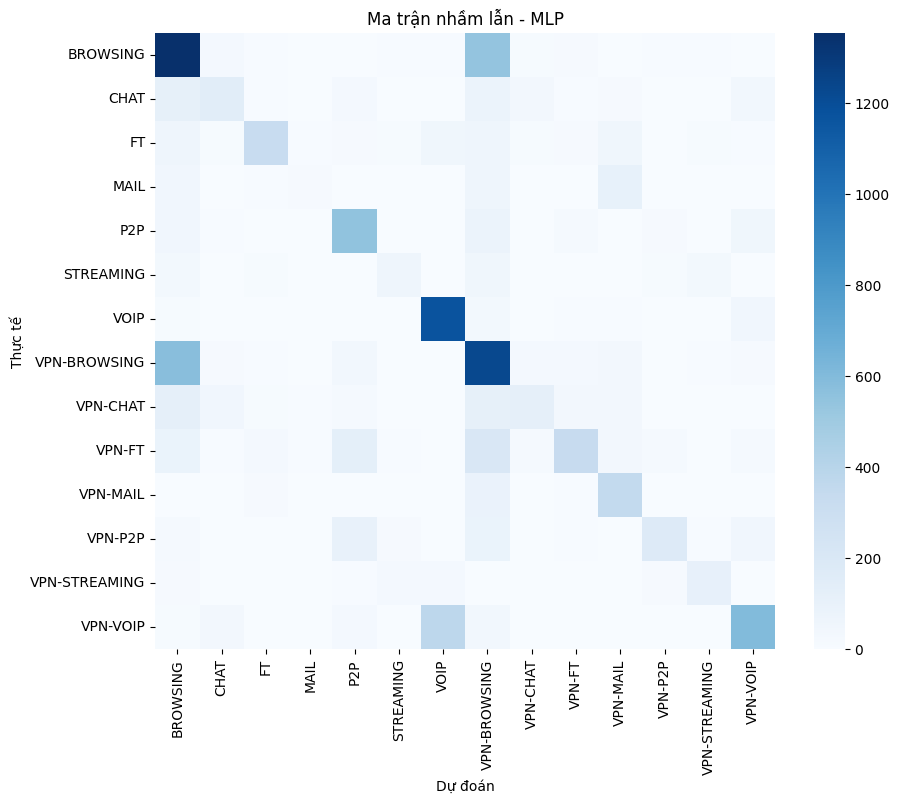

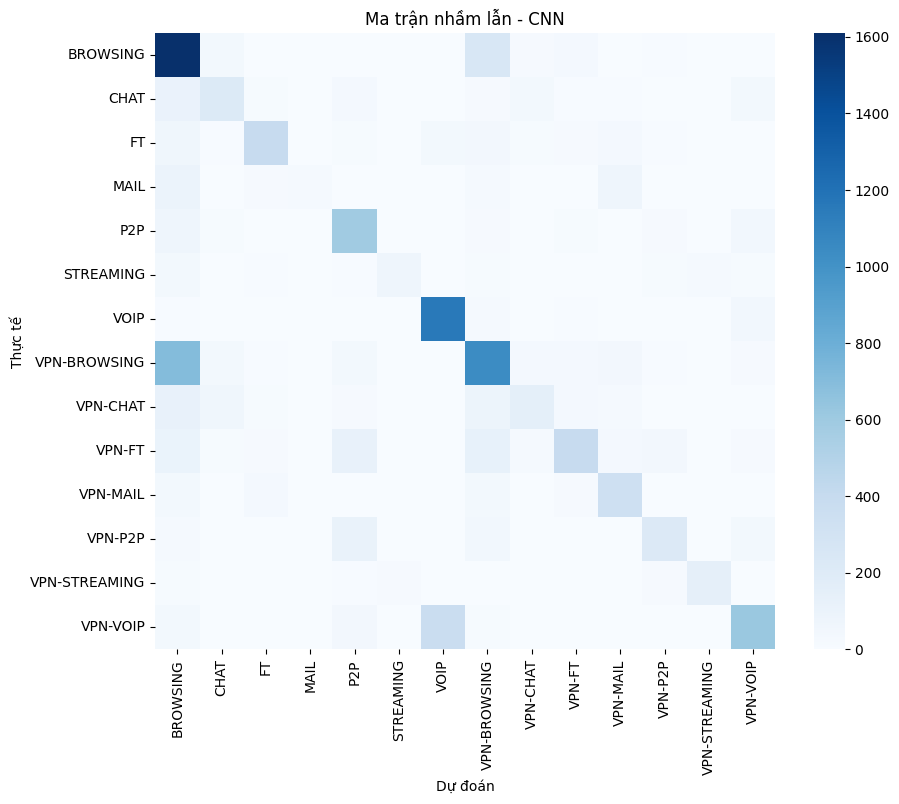

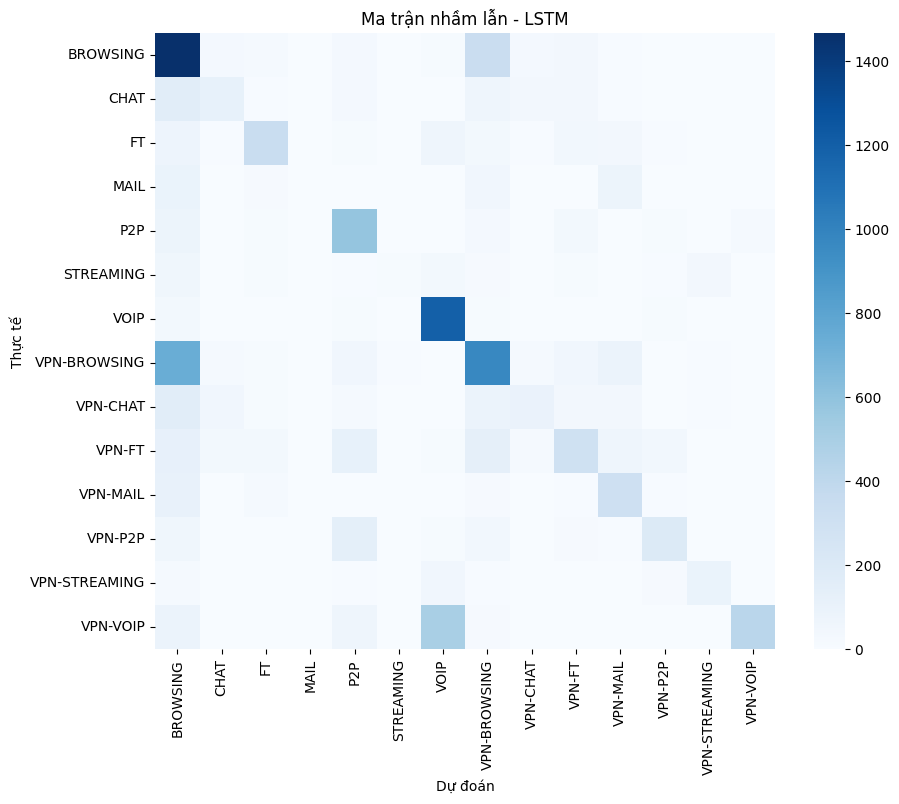

In [14]:
def plot_confusion(y_true, y_pred, labels, name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=False, cmap='Blues')
    plt.title(f"Ma trận nhầm lẫn - {name}")
    plt.xlabel("Dự đoán")
    plt.ylabel("Thực tế")

    plt.xticks(np.arange(len(labels))+0.5, labels, rotation=90)
    plt.yticks(np.arange(len(labels))+0.5, labels, rotation=0)
    plt.show()

plot_confusion(y_test, y_pred_mlp, label_names, "MLP")
plot_confusion(y_test, y_pred_cnn, label_names, "CNN")
plot_confusion(y_test, y_pred_lstm, label_names, "LSTM")


# 10. Biểu đồ training history

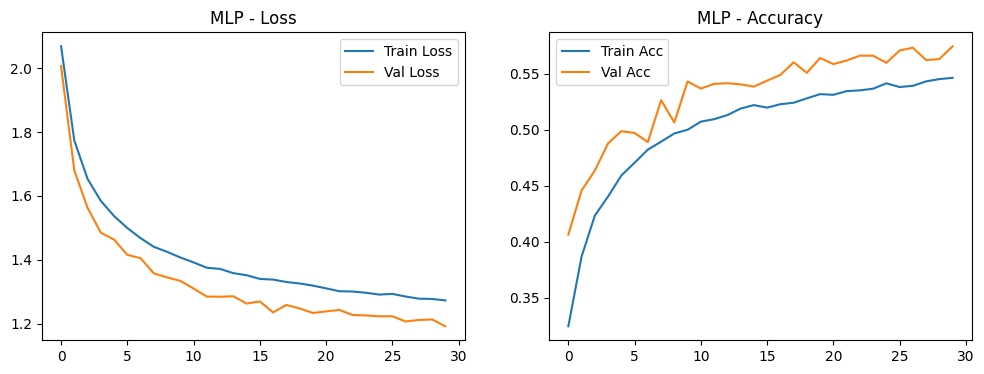

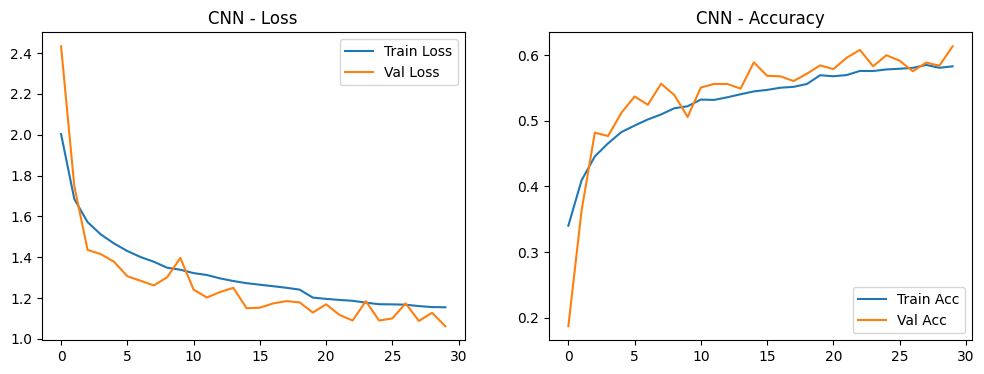

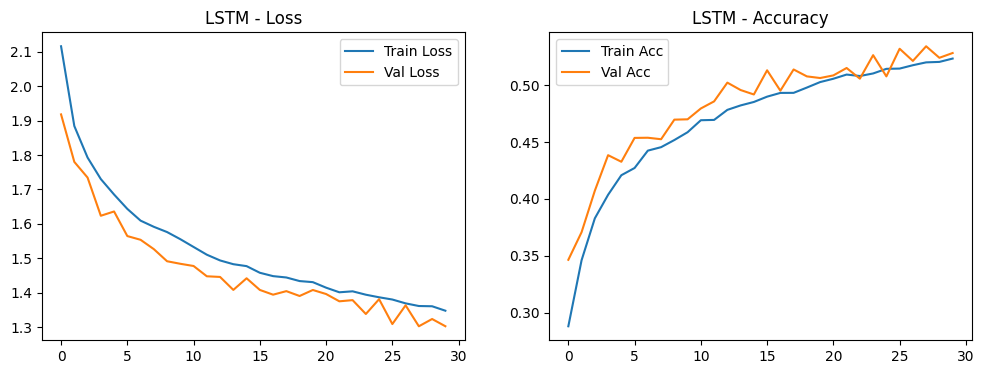

In [15]:
def plot_history(hist, name):
    plt.figure(figsize=(12,4))
    # Loss
    plt.subplot(1,2,1)
    plt.plot(hist.history['loss'], label='Train Loss')
    if 'val_loss' in hist.history:
        plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.title(f"{name} - Loss")
    plt.legend()
    # Accuracy
    plt.subplot(1,2,2)
    if 'accuracy' in hist.history:
        plt.plot(hist.history['accuracy'], label='Train Acc')
    if 'val_accuracy' in hist.history:
        plt.plot(hist.history['val_accuracy'], label='Val Acc')
    plt.title(f"{name} - Accuracy")
    plt.legend()
    plt.show()

plot_history(histories["MLP"], "MLP")
plot_history(histories["CNN"], "CNN")
plot_history(histories["LSTM"], "LSTM")

# 11. So sánh các mô hình

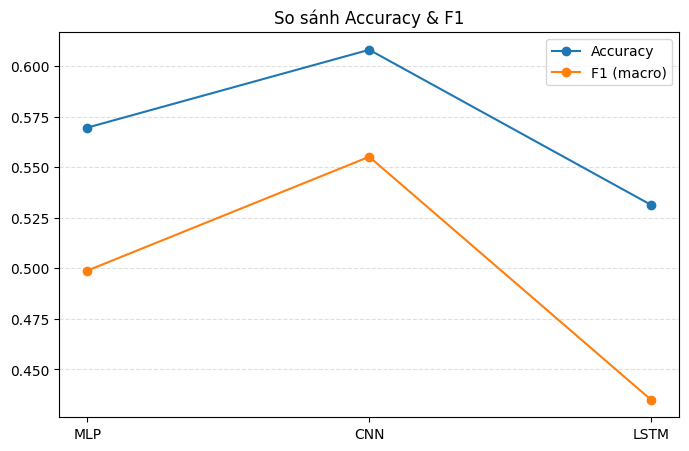

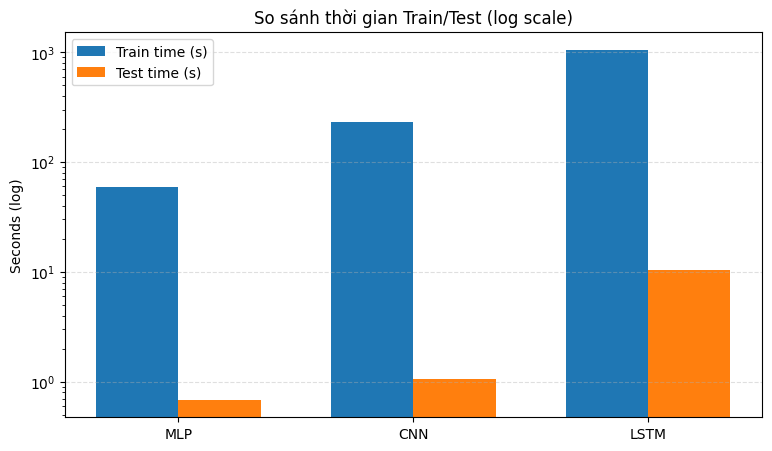

In [16]:
names = list(results.keys())
accs = [results[m]["acc"] for m in names]
f1s  = [results[m]["f1_macro"] for m in names]

plt.figure(figsize=(8,5))
plt.plot(names, accs, marker='o', label='Accuracy')
plt.plot(names, f1s, marker='o', label='F1 (macro)')
plt.title("So sánh Accuracy & F1")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

train_times = [results[m]["train_time"] for m in names]
test_times  = [results[m]["test_time"] for m in names]

x = np.arange(len(names))
width = 0.35

plt.figure(figsize=(9,5))
plt.bar(x - width/2, train_times, width, label="Train time (s)")
plt.bar(x + width/2, test_times, width, label="Test time (s)")
plt.xticks(x, names)
plt.yscale("log")
plt.title("So sánh thời gian Train/Test (log scale)")
plt.ylabel("Seconds (log)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

# 12. Bảng tổng hợp

In [17]:
summary = pd.DataFrame(results).T
print("\n=== SUMMARY ===")
print(summary)


=== SUMMARY ===
           acc  f1_macro   train_time  test_time
MLP   0.569531   0.49886    59.541388   0.684417
CNN   0.607986   0.55511   232.732247   1.058667
LSTM  0.531337   0.43501  1052.122230  10.308472
